In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import seaborn as sns
import pickle
from collections import OrderedDict
import re

In [2]:
DATADIR = '/rds/general/user/mc4117/home/WeatherBench/data/'

In [3]:
var_dict = {
    'geopotential': ('z', [500, 850]),
    'temperature': ('t', [500, 850]),
    'specific_humidity': ('q', [850]),
    '2m_temperature': ('t2m', None),
    'potential_vorticity': ('pv', [50, 100]),
    'constants': ['lsm', 'orography']
}

In [4]:
ds_list = []

for long_var, params in var_dict.items():
    if long_var == 'constants':
        ds_list.append(xr.open_mfdataset(f'{DATADIR}/{long_var}/*.nc', combine='by_coords'))
    else:
        var, levels = params
        if levels is not None:
            ds_list.append(xr.open_mfdataset(f'{DATADIR}/{long_var}/*.nc', combine='by_coords').sel(level = levels))
        else:
            ds_list.append(xr.open_mfdataset(f'{DATADIR}/{long_var}/*.nc', combine='by_coords'))

In [5]:
ds_whole = xr.merge(ds_list)

In [6]:
ds_train = ds_whole.sel(time=slice('1979', '2015'))
ds_valid = ds_whole.sel(time=slice('2016', '2016'))
ds_test = ds_whole.sel(time=slice('2017', '2018'))

In [7]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, 
                 mean=None, std=None, output_vars=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """

        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        level_names = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for long_var, params in var_dict.items():
            if long_var == 'constants': 
                for var in params:
                    data.append(ds[var].expand_dims(
                        {'level': generic_level, 'time': ds.time}, (1, 0)
                    ))
                    level_names.append(var)
            else:
                var, levels = params
                try:
                    data.append(ds[var].sel(level=levels))
                    level_names += [f'{var}_{level}' for level in levels]
                except ValueError:
                    data.append(ds[var].expand_dims({'level': generic_level}, 1))
                    level_names.append(var)

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.data['level_names'] = xr.DataArray(
            level_names, dims=['level'], coords={'level': self.data.level})
        if output_vars is None:
            self.output_idxs = range(len(dg_valid.data.level))
        else:
            self.output_idxs = [i for i, l in enumerate(self.data.level_names.values) 
                                if any([bool(re.match(o, l)) for o in output_vars])]
        
        # Normalize
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
#         self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        self.std = self.data.std(('time', 'lat', 'lon')).compute() if std is None else std
        self.data = (self.data - self.mean) / self.std
        
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        #if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time, level=self.output_idxs).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

In [8]:
bs=32
lead_time=72
output_vars = ['z_500', 't_850']

In [9]:
# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(ds_train, var_dict, lead_time, batch_size=bs, load=True, 
                         output_vars=output_vars)
dg_valid = DataGenerator(ds_valid, var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, 
                         shuffle=False, output_vars=output_vars)

In [32]:
dg_train.data.max(('time', 'lat', 'lon')).compute()

<xarray.DataArray 'z' (level: 10)>
array([1.5343828, 2.7397368, 2.3747673, 2.514359 , 4.3858833, 2.1296566,
       5.0623574, 9.274969 , 1.444254 , 5.26901  ], dtype=float32)
Coordinates:
  * level        (level) int64 500 850 500 850 850 1 50 100 1 1
    level_names  (level) <U9 'z_500' 'z_850' 't_500' ... 'lsm' 'orography'

In [ ]:
flattened_0 = np.array(dg_train.data[..., 0]).flatten()
flattened_1 = np.array(dg_train.data[..., 1]).flatten()
flattened_2 = np.array(dg_train.data[..., 2]).flatten()
flattened_3 = np.array(dg_train.data[..., 3]).flatten()
flattened_4 = np.array(dg_train.data[..., 4]).flatten()
flattened_5 = np.array(dg_train.data[..., 5]).flatten()
flattened_6 = np.array(dg_train.data[..., 6]).flatten()
flattened_7 = np.array(dg_train.data[..., 7]).flatten()
flattened_8 = np.array(dg_train.data[..., 8]).flatten()
flattened_9 = np.array(dg_train.data[..., 9]).flatten()

In [ ]:
plt.hist(flattened_0)
plt.show()
plt.hist(flattened_1)
plt.show()
plt.hist(flattened_2)
plt.show()
plt.hist(flattened_3)
plt.show()
plt.hist(flattened_4)
plt.show()
plt.hist(flattened_5)
plt.show()
plt.hist(flattened_6)
plt.show()
plt.hist(flattened_7)
plt.show()
plt.hist(flattened_8)
plt.show()
plt.hist(flattened_9)
plt.show()

In [10]:
sh = ds_train.q.sel(level = 850)

mean = sh.mean(('time', 'lat', 'lon')).compute()
std = sh.std(('time', 'lat', 'lon')).compute()

norm_sh = (sh-mean)/std

In [11]:
sh_flatten = np.array(sh.data).flatten()

In [12]:
norm_sh_flatten = np.array(norm_sh.data).flatten()

(array([2.67599558e+08, 1.35096680e+08, 8.09640340e+07, 5.62585720e+07,
        5.07873540e+07, 6.14364030e+07, 1.16658290e+07, 4.21303000e+05,
        1.03560000e+04, 3.90000000e+01]),
 array([-1.76648413e-07,  2.25514569e-03,  4.51046834e-03,  6.76579028e-03,
         9.02111270e-03,  1.12764351e-02,  1.35317575e-02,  1.57870799e-02,
         1.80424023e-02,  2.02977248e-02,  2.25530472e-02], dtype=float32),
 <BarContainer object of 10 artists>)

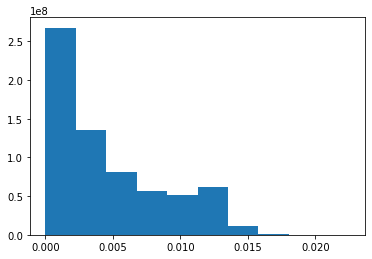

In [13]:
plt.hist(sh_flatten)

(array([2.67599601e+08, 1.35096660e+08, 8.09640330e+07, 5.62585650e+07,
        5.07873700e+07, 6.14363720e+07, 1.16658310e+07, 4.21301000e+05,
        1.03560000e+04, 3.90000000e+01]),
 array([-1.1125644 , -0.56271964, -0.01287489,  0.5369699 ,  1.0868146 ,
         1.6366594 ,  2.1865041 ,  2.736349  ,  3.2861938 ,  3.8360386 ,
         4.3858833 ], dtype=float32),
 <BarContainer object of 10 artists>)

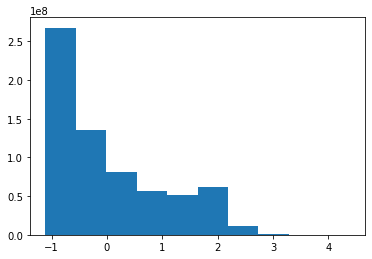

In [14]:
plt.hist(norm_sh_flatten)

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(sh_flatten.reshape(-1,1))
transformed_data = scaler.transform(sh_flatten.reshape(-1,1))

(array([2.67599558e+08, 1.35096652e+08, 8.09640620e+07, 5.62585720e+07,
        5.07873540e+07, 6.14364030e+07, 1.16658290e+07, 4.21303000e+05,
        1.03560000e+04, 3.90000000e+01]),
 array([0.        , 0.09999999, 0.19999999, 0.29999998, 0.39999998,
        0.49999997, 0.59999996, 0.6999999 , 0.79999995, 0.9       ,
        0.99999994], dtype=float32),
 <BarContainer object of 10 artists>)

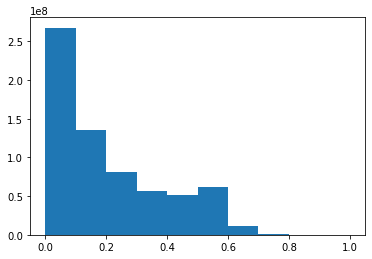

In [25]:
plt.hist(transformed_data)

In [26]:
X_normalized = preprocessing.normalize(transformed_data.reshape(-1,1), norm='l2')

(array([1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.64240127e+08]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

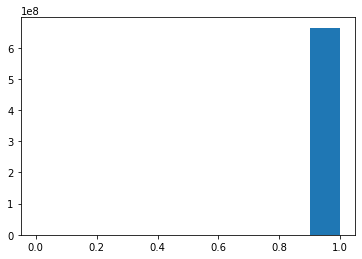

In [27]:
plt.hist(X_normalized)

In [31]:
# from sklearn import preprocessing
normalizer = preprocessing.Normalizer()

In [22]:
normalized_sh = normalizer.fit(sh_flatten.reshape(-1,1)).transform(sh_flatten.reshape(-1,1))

(array([2.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.64240126e+08]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

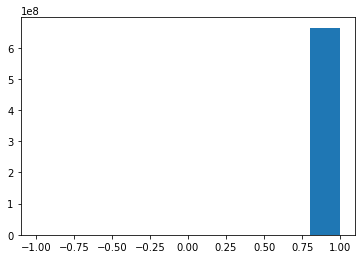

In [23]:
plt.hist(normalized_sh)